## Unsupervised Decision Tree

In [6]:
#Importing the required libraries
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.cluster import KMeans

Use the dataset in the results2 folder

## DecisionTree: max_leaf_nodes = num of class

In [2]:
# Prepare dataset
# CHANGE THIS
X_train = np.load("results2/X_train.npy") 
X_test = np.load("results2/X_test.npy") 
y_test = np.load("results2/y_test.npy") 
y_train = np.load("results2/y_train.npy")

In [65]:
def train(X_train, X_test, y_test, y_train, number_of_class):
    '''
    We treat this as a regression problem, basically just treat the dataset as our label. 
    Spliting the decision tree based on the variance reduction rule.
    Returns the test dataset with assigned cluster index
    '''
    # Regression Decision Tree
    reg = DecisionTreeRegressor(criterion="squared_error", max_leaf_nodes=number_of_class)
    reg = reg.fit(X_train,X_train)
    y_pred = reg.predict(X_test) #values in y_pred are cluster centers!
    
    unique = np.unique(y_pred, axis=0) # a numpy array with only unique clusters
    
    # assign a cluster index to our prediction points
    cluster_index = np.zeros((y_pred.shape[0], )) 
    for i, cluster in enumerate(unique):
        for j, datapoint in enumerate(y_pred):
            if np.array_equal(datapoint, cluster):
                cluster_index[j] = int(i)
    return cluster_index

def get_population_in_cluster_i(y_test, cluster_index, cluster_i ):
    '''
    This is function that returns the number of labels for cluster_i
    '''
    true_label, counts =  np.unique(y_test[np.where(np.array(cluster_index)==cluster_i)[0]], return_counts=True)
    #add dummy into counts 
    for i in range(number_of_class):
        if i not in true_label:
            counts = np.insert(counts, i , 0)
    return counts

def label_assign(y_test, cluster_index):
    '''
    Perform two accuracy measurements
    '''
    
    # Use the majority rule to assign a label to each cluster
    
    population_of_cluster = np.asmatrix([get_population_in_cluster_i(y_test, cluster_index,i) for i in range(number_of_class)])
    # Assigned label for each cluster
    labels = np.argmax(population_of_cluster,axis=1)
    labels_simple = []
    for i in np.array(labels):
        labels_simple.append(i[0])
    print("When using the simple majority rule to assign a label to each cluster:")
    for i, label in enumerate(labels_simple):
        print("The label for cluster", i, "is:", label)
    
    # Majority Rule with assigned weight
    
    #precentage_in_cluster = normalize(population_of_cluster, axis=1, norm='l1')
    #print(precentage_in_cluster)
    precentage_in_label = normalize(population_of_cluster, axis=0, norm='l1')
    #print(precentage_in_label)
    score_matrix = np.multiply(population_of_cluster,precentage_in_label)
    #score_matrix
    norm_score = normalize(score_matrix, axis=1, norm='l1')
    labels_weight = np.argmax(norm_score, axis=1)
    print("When using weighted majority rule to assign a label to each cluster:")
    for i, label in enumerate(labels_weight):
        print("The label for cluster", i, "is:", label)
    
    return labels_simple, labels_weight
    
def get_accuracy(cluster_new_label, cluster_index, y_test):
    labels = [cluster_new_label[int(ci)] for ci in cluster_index]
    return accuracy_score(y_test, labels)
    

In [66]:
# Wrapper function
number_of_class = 5
cluster_index = train(X_train, X_test, y_test, y_train, number_of_class)
labels_simple, labels_weight = label_assign(y_test, cluster_index)

accuracy_simple = get_accuracy(labels_simple, cluster_index, y_test)
accuracy_weight = get_accuracy(labels_weight, cluster_index, y_test)
print("Accuracy score using unweighted labeling method", accuracy_simple)
print("Accuracy score using weighted labeling method", accuracy_weight)

When using the simple majority rule to assign a label to each cluster:
The label for cluster 0 is: 4
The label for cluster 1 is: 3
The label for cluster 2 is: 3
The label for cluster 3 is: 3
The label for cluster 4 is: 3
When using weighted majority rule to assign a label to each cluster:
The label for cluster 0 is: 4
The label for cluster 1 is: 3
The label for cluster 2 is: 3
The label for cluster 3 is: 4
The label for cluster 4 is: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [68]:
print(accuracy_simple)
print(accuracy_weight)

0.3522633744855967
0.3506172839506173


Text(0.5, 1.0, 'For class 0, number of elements in each cluster')

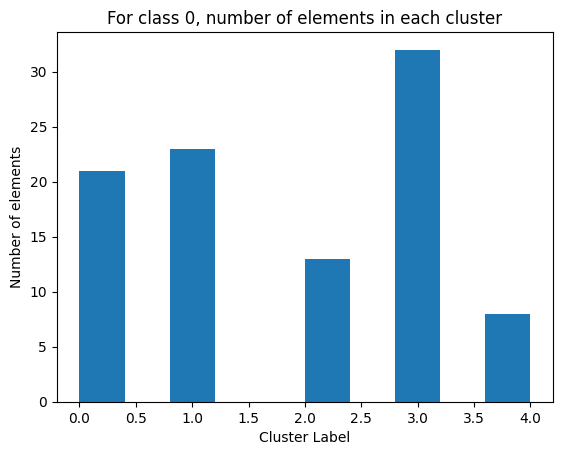

In [25]:
# Number of elements in each cluster
cluster_size = [len(np.where(np.array(cluster_index)==i)[0]) for i in range(number_of_class)]
# Use true label to evaluate our performance
# For class 0 (true), how many elements are there in each cluster
plt.hist(cluster_index[np.where(np.array(y_test)==0)])
plt.xlabel("Cluster Label")
plt.ylabel("Number of elements")
plt.title("For class 0, number of elements in each cluster")

## Decision Tree: Merge clusters

In [80]:
def train_merge(X_train, X_test, y_test, y_train, number_of_class, max_leaf_nodes):
    reg = DecisionTreeRegressor(criterion="squared_error", max_leaf_nodes=max_leaf_nodes)
    reg = reg.fit(X_train,X_train)
    y_pred = reg.predict(X_test)
    
    # Regroup using KMeans
    kmeans = KMeans(n_clusters=number_of_class,random_state=0).fit(y_pred)
    cluster_index = kmeans.labels_
    return cluster_index
    

In [83]:
# Wrapper function
number_of_class = 5
max_leaf_nodes = 50
cluster_index = train_merge(X_train, X_test, y_test, y_train, number_of_class, max_leaf_nodes)
labels_simple, labels_weight = label_assign(y_test, cluster_index)

accuracy_simple = get_accuracy(labels_simple, cluster_index, y_test)
accuracy_weight = get_accuracy(labels_weight, cluster_index, y_test)
print("Accuracy score using unweighted labeling method", accuracy_simple)
print("Accuracy score using weighted labeling method", accuracy_weight)

When using the simple majority rule to assign a label to each cluster:
The label for cluster 0 is: 3
The label for cluster 1 is: 3
The label for cluster 2 is: 3
The label for cluster 3 is: 3
The label for cluster 4 is: 3
When using weighted majority rule to assign a label to each cluster:
The label for cluster 0 is: 1
The label for cluster 1 is: 3
The label for cluster 2 is: 4
The label for cluster 3 is: 3
The label for cluster 4 is: 3
Accuracy score using unweighted labeling method 0.34897119341563787
Accuracy score using weighted labeling method 0.3390946502057613


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
